## Import Libraries

In [26]:
import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from collections import Counter
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, GaussianBlur, Grayscale
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, Dataset

import cv2 
from PIL import Image, ImageFilter, ImageOps
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import dill
import torch.multiprocessing as mp

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # as M1 Mac Does not have a dedicated GPU

##### Specify the path to the locally saved dataset

In [28]:
train_data_dir = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/2nd_Dataset'
original_dataset = datasets.ImageFolder(train_data_dir)

In [29]:
class ContrastStretching:
    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Check if the image is grayscale or RGB
        if img_np.ndim == 2:  # Grayscale image
            img_np = self.apply_contrast_stretching(img_np)
        elif img_np.ndim == 3:  # RGB image
            # Apply contrast stretching to each channel individually
            for i in range(img_np.shape[-1]):
                img_np[:, :, i] = self.apply_contrast_stretching(img_np[:, :, i])
        
        # Convert back to PIL Image
        return Image.fromarray(img_np.astype('uint8'))
    
    def apply_contrast_stretching(self, channel):
        in_min, in_max = np.percentile(channel, (0, 100))
        out_min, out_max = 0, 255
        channel = np.clip((channel - in_min) * (out_max - out_min) / (in_max - in_min) + out_min, out_min, out_max)
        return channel

class UnsharpMask:
    def __init__(self, radius=1, percent=100, threshold=3):
        self.radius = radius
        self.percent = percent
        self.threshold = threshold

    def __call__(self, img):
        return img.filter(ImageFilter.UnsharpMask(radius=self.radius, 
                                                  percent=self.percent, 
                                                  threshold=self.threshold
                                                 ))

class GaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        sigma = np.random.uniform(self.sigma[0], self.sigma[1])
        img = img.filter(ImageFilter.GaussianBlur(sigma))
        return img

#### Preprocess the dataset

In [30]:
preprocess_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.Lambda(lambda img: transforms.functional.rotate(img, 90)),  
    ContrastStretching(),
    UnsharpMask(radius=1, percent=100, threshold=3),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
])

preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [17]:
def calculate_psnr_ssim(original_dataset, preprocessed_dataset, num_samples=100, resize=(224, 224)):
    psnr_values = []
    ssim_values = []

    for i in range(num_samples):
        original_img = original_dataset[i][0] # original MRI
        preprocessed_img = preprocessed_dataset[i][0] # preprocessed MRI

        if not isinstance(original_img, Image.Image):
            original_img = to_pil_image(original_img)
        if not isinstance(preprocessed_img, Image.Image):
            preprocessed_img = to_pil_image(preprocessed_img)

        # Convert MRI to grayscale
        original_img = original_img.convert("L")
        preprocessed_img = preprocessed_img.convert("L")

        # Resize images
        original_img = original_img.resize(resize)
        preprocessed_img = preprocessed_img.resize(resize)

        # Convert images to numpy arrays
        original_img_np = np.array(original_img)
        preprocessed_img_np = np.array(preprocessed_img)

        # Calculate PSNR and SSIM
        psnr = peak_signal_noise_ratio(original_img_np, preprocessed_img_np, data_range=original_img_np.max() - original_img_np.min())
        ssim = structural_similarity(original_img_np, preprocessed_img_np)

        psnr_values.append(psnr)
        ssim_values.append(ssim)

    # Compute average PSNR and SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Example usage
avg_psnr, avg_ssim = calculate_psnr_ssim(original_dataset, preprocessed_dataset)
print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")

Average PSNR: 13.143174255195463, Average SSIM: 0.18948721108857092


preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.Lambda(lambda x: x.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))),
    transforms.ToTensor()
)

Average PSNR: 9.729432125669954, Average SSIM: 0.2833625979364462
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.ToTensor()
)

Average PSNR: 10.2026194786185, Average SSIM: 0.32374658927511385
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)), 
    transforms.ToTensor(),
)

Average PSNR: 34.479706650199184, Average SSIM: 0.9638484917028203

____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.0)), 
    transforms.ToTensor(),
)

Average PSNR: 40.03000513450271, Average SSIM: 0.9923509776637894

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 28.919164968402907, Average SSIM: 0.9646276430637585

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    ContrastStretching(),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=1, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 27.194490517269728, Average SSIM: 0.8948121010151182

#### MRI scan counts in each class of the dataset

In [8]:
MildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/2nd_Dataset/MildDemented'
ModerateDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/2nd_Dataset/ModerateDemented'
NonDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/2nd_Dataset/NonDemented'
VeryMildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/2nd_Dataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 5002
Number of images in ModerateDemented: 488
Number of images in NonDemented: 5010
Number of images in VeryMildDemented: 5000

Total MRIs in the dataset = 15500


#### Sample MRI before and after preprocessing

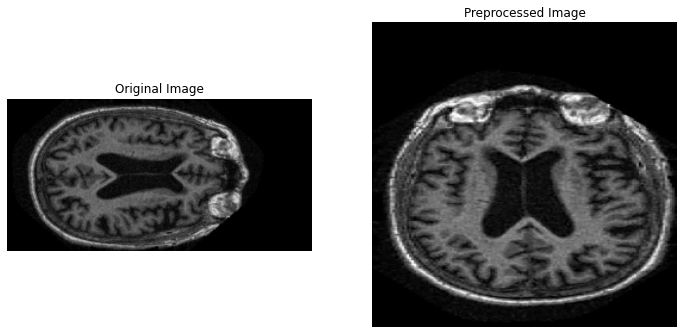

In [31]:
sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[0])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

### Dataset splitting & creating DataLoaders

In [32]:
train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [40]:
all_labels = [label for _, label in train_dataset]
class_distribution = Counter(all_labels)
print(class_distribution)

Counter({2: 6737, 0: 6238, 3: 6236, 1: 4577})


## Building CNN Model 2

In [33]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=32):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn(self.conv(x)))
        out += residual
        return F.relu(out)

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomEfficientNet, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a new one
        num_ftrs = self.base_model.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        # Add SEBlock and ResidualBlock to the end of the features, before the avgpool
        self.base_model.features.add_module("SEBlock", SEBlock(1280))  # Adjust in_channels accordingly

    def forward(self, x):
        # Process through EfficientNet up to before avgpool
        x = self.base_model.features(x)
        
        # Now x is a 4D tensor, and we can apply SEBlock and ResidualBlock directly
        # No need for separate calls, as they are part of the features module
        
        # Apply avgpool and classifier
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Creating the model and moving to device
model2 = CustomEfficientNet(num_classes=4).to(device)

# For a summary, ensure the input size matches your dataset
summary(model2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

# Train Customized EfficientNet-B0

Epoch 1 [train] Progress: 100%|██████████| 1357/1357 [10:57<00:00,  2.06batch/s]


train Loss: 1.0232 Acc: 0.5582


Epoch 1 [val] Progress: 100%|██████████████| 291/291 [02:12<00:00,  2.19batch/s]


val Loss: 0.8239 Acc: 0.6563


Epoch 2 [train] Progress: 100%|██████████| 1357/1357 [11:59<00:00,  1.88batch/s]


train Loss: 0.8701 Acc: 0.6422


Epoch 2 [val] Progress: 100%|██████████████| 291/291 [02:16<00:00,  2.13batch/s]


val Loss: 0.7269 Acc: 0.7067


Epoch 3 [train] Progress: 100%|██████████| 1357/1357 [11:53<00:00,  1.90batch/s]


train Loss: 0.8069 Acc: 0.6663


Epoch 3 [val] Progress: 100%|██████████████| 291/291 [02:16<00:00,  2.13batch/s]


val Loss: 0.6378 Acc: 0.7548


Epoch 4 [train] Progress: 100%|██████████| 1357/1357 [11:46<00:00,  1.92batch/s]


train Loss: 0.7513 Acc: 0.6941


Epoch 4 [val] Progress: 100%|██████████████| 291/291 [02:17<00:00,  2.12batch/s]


val Loss: 0.5888 Acc: 0.7811


Epoch 5 [train] Progress: 100%|██████████| 1357/1357 [11:44<00:00,  1.93batch/s]


train Loss: 0.7031 Acc: 0.7101


Epoch 5 [val] Progress: 100%|██████████████| 291/291 [02:18<00:00,  2.09batch/s]


val Loss: 0.5417 Acc: 0.7961


Epoch 6 [train] Progress: 100%|██████████| 1357/1357 [11:34<00:00,  1.95batch/s]


train Loss: 0.6718 Acc: 0.7257


Epoch 6 [val] Progress: 100%|██████████████| 291/291 [02:14<00:00,  2.17batch/s]


val Loss: 0.4938 Acc: 0.8103


Epoch 7 [train] Progress: 100%|██████████| 1357/1357 [11:19<00:00,  2.00batch/s]


train Loss: 0.6381 Acc: 0.7363


Epoch 7 [val] Progress: 100%|██████████████| 291/291 [02:12<00:00,  2.20batch/s]


val Loss: 0.4513 Acc: 0.8383


Epoch 8 [train] Progress: 100%|██████████| 1357/1357 [11:19<00:00,  2.00batch/s]


train Loss: 0.6125 Acc: 0.7534


Epoch 8 [val] Progress: 100%|██████████████| 291/291 [02:13<00:00,  2.18batch/s]


val Loss: 0.4159 Acc: 0.8533


Epoch 9 [train] Progress: 100%|██████████| 1357/1357 [11:32<00:00,  1.96batch/s]


train Loss: 0.5848 Acc: 0.7655


Epoch 9 [val] Progress: 100%|██████████████| 291/291 [02:13<00:00,  2.18batch/s]


val Loss: 0.3982 Acc: 0.8490


Epoch 10 [train] Progress: 100%|█████████| 1357/1357 [11:41<00:00,  1.94batch/s]


train Loss: 0.5611 Acc: 0.7779


Epoch 10 [val] Progress: 100%|█████████████| 291/291 [02:14<00:00,  2.16batch/s]


val Loss: 0.3838 Acc: 0.8594


Epoch 11 [train] Progress: 100%|█████████| 1357/1357 [11:31<00:00,  1.96batch/s]


train Loss: 0.5341 Acc: 0.7889


Epoch 11 [val] Progress: 100%|█████████████| 291/291 [02:15<00:00,  2.16batch/s]


val Loss: 0.3663 Acc: 0.8675


Epoch 12 [train] Progress: 100%|█████████| 1357/1357 [11:27<00:00,  1.97batch/s]


train Loss: 0.5247 Acc: 0.7890


Epoch 12 [val] Progress: 100%|█████████████| 291/291 [02:13<00:00,  2.18batch/s]


val Loss: 0.3367 Acc: 0.8796


Epoch 13 [train] Progress: 100%|█████████| 1357/1357 [11:37<00:00,  1.95batch/s]


train Loss: 0.4917 Acc: 0.8097


Epoch 13 [val] Progress: 100%|█████████████| 291/291 [02:12<00:00,  2.20batch/s]


val Loss: 0.3111 Acc: 0.8916


Epoch 14 [train] Progress: 100%|█████████| 1357/1357 [11:32<00:00,  1.96batch/s]


train Loss: 0.4763 Acc: 0.8159


Epoch 14 [val] Progress: 100%|█████████████| 291/291 [02:15<00:00,  2.14batch/s]


val Loss: 0.2949 Acc: 0.9062


Epoch 15 [train] Progress: 100%|█████████| 1357/1357 [12:16<00:00,  1.84batch/s]


train Loss: 0.4636 Acc: 0.8191


Epoch 15 [val] Progress: 100%|█████████████| 291/291 [02:15<00:00,  2.14batch/s]


val Loss: 0.2915 Acc: 0.8920


Epoch 16 [train] Progress: 100%|█████████| 1357/1357 [11:40<00:00,  1.94batch/s]


train Loss: 0.4362 Acc: 0.8285


Epoch 16 [val] Progress: 100%|█████████████| 291/291 [02:15<00:00,  2.15batch/s]


val Loss: 0.2653 Acc: 0.9114


Epoch 17 [train] Progress: 100%|█████████| 1357/1357 [11:51<00:00,  1.91batch/s]


train Loss: 0.4356 Acc: 0.8315


Epoch 17 [val] Progress: 100%|█████████████| 291/291 [02:16<00:00,  2.13batch/s]


val Loss: 0.2597 Acc: 0.9071


Epoch 18 [train] Progress: 100%|█████████| 1357/1357 [11:49<00:00,  1.91batch/s]


train Loss: 0.4270 Acc: 0.8347


Epoch 18 [val] Progress: 100%|█████████████| 291/291 [02:14<00:00,  2.16batch/s]


val Loss: 0.2373 Acc: 0.9187


Epoch 19 [train] Progress: 100%|█████████| 1357/1357 [13:04<00:00,  1.73batch/s]


train Loss: 0.4115 Acc: 0.8424


Epoch 19 [val] Progress: 100%|█████████████| 291/291 [02:42<00:00,  1.79batch/s]


val Loss: 0.2523 Acc: 0.9097


Epoch 20 [train] Progress: 100%|█████████| 1357/1357 [14:02<00:00,  1.61batch/s]


train Loss: 0.4003 Acc: 0.8465


Epoch 20 [val] Progress: 100%|█████████████| 291/291 [02:15<00:00,  2.14batch/s]


val Loss: 0.2371 Acc: 0.9135


Epoch 21 [train] Progress: 100%|█████████| 1357/1357 [11:44<00:00,  1.93batch/s]


train Loss: 0.3860 Acc: 0.8551


Epoch 21 [val] Progress: 100%|█████████████| 291/291 [01:58<00:00,  2.45batch/s]


val Loss: 0.2207 Acc: 0.9269


Epoch 22 [train] Progress: 100%|█████████| 1357/1357 [10:15<00:00,  2.20batch/s]


train Loss: 0.3680 Acc: 0.8632


Epoch 22 [val] Progress: 100%|█████████████| 291/291 [01:59<00:00,  2.44batch/s]


val Loss: 0.2017 Acc: 0.9277


Epoch 23 [train] Progress: 100%|█████████| 1357/1357 [10:14<00:00,  2.21batch/s]


train Loss: 0.3652 Acc: 0.8597


Epoch 23 [val] Progress: 100%|█████████████| 291/291 [02:00<00:00,  2.42batch/s]


val Loss: 0.1931 Acc: 0.9333


Epoch 24 [train] Progress: 100%|█████████| 1357/1357 [10:09<00:00,  2.23batch/s]


train Loss: 0.3517 Acc: 0.8667


Epoch 24 [val] Progress: 100%|█████████████| 291/291 [01:58<00:00,  2.46batch/s]


val Loss: 0.1884 Acc: 0.9351


Epoch 25 [train] Progress: 100%|█████████| 1357/1357 [11:40<00:00,  1.94batch/s]


train Loss: 0.3446 Acc: 0.8722


Epoch 25 [val] Progress: 100%|█████████████| 291/291 [02:12<00:00,  2.20batch/s]


val Loss: 0.1738 Acc: 0.9454


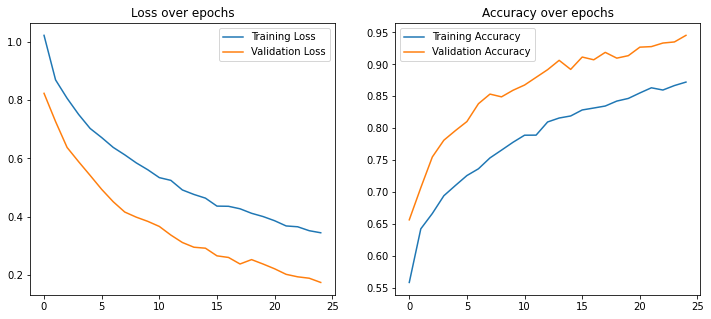

In [34]:
criterion = nn.CrossEntropyLoss()
trainable_params = filter(lambda p: p.requires_grad, model2.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
torch.autograd.set_detect_anomaly(True)

def train_epoch(epoch_index, train_loader, model, optimizer):
    model.train()  
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    model.eval() 
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

# Training loop
num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 8

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, model2, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, model2)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model2.state_dict(), 'model2_test4.pth')
#     else:
#         trigger_times += 1
#         if trigger_times >= patience:
#             print(f"Early stopping at epoch {epoch+1}")
#             break

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

### Classification Report of the trained Modified EfficientNet B0

In [35]:
# classification report (val loader)
model2 = CustomEfficientNet(num_classes=4).to(device)

model2.load_state_dict(torch.load('model2_test4.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model2, val_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.95      0.95      0.95       771
ModerateDemented       0.86      0.97      0.91        59
     NonDemented       0.92      0.97      0.94       740
VeryMildDemented       0.95      0.89      0.92       755

        accuracy                           0.94      2325
       macro avg       0.92      0.94      0.93      2325
    weighted avg       0.94      0.94      0.94      2325



In [36]:
def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model2, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.94      0.95      0.95       747
ModerateDemented       0.94      0.90      0.92        68
     NonDemented       0.92      0.97      0.94       753
VeryMildDemented       0.95      0.90      0.92       757

        accuracy                           0.94      2325
       macro avg       0.94      0.93      0.93      2325
    weighted avg       0.94      0.94      0.94      2325



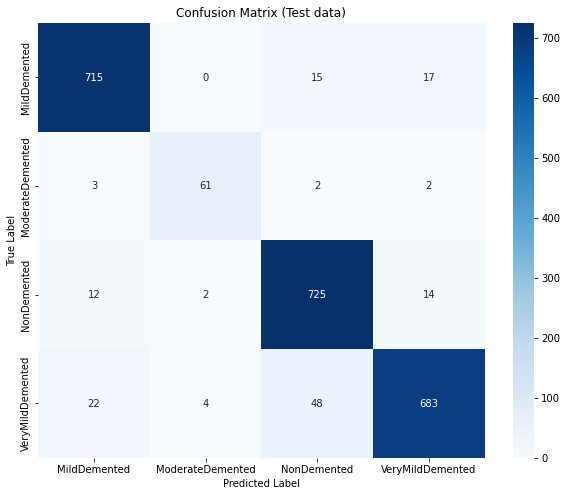

In [37]:
# Confusion Matrix on Test Loader - modified EfficientNet B0

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(model2, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [38]:
# Save the best model locally (model2 - modified EfficientNetB0)

model_save_path = '/Users/savin/Desktop/FYP/final_chapters/Model_Testing' 
os.makedirs(model_save_path, exist_ok=True) 
model_save_file = os.path.join(model_save_path, 'model2_generalization_test.pth')

torch.save(model2.state_dict(), model_save_file)

print(f'Model saved to {model_save_file}')

Model saved to /Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_generalization_test.pth


In [41]:
model2_generalization_test = CustomEfficientNet(num_classes=4)
model2_generalization_test.load_state_dict(torch.load("/Users/savin/Desktop/FYP/final_chapters/Model_Testing/model2_generalization_test.pth"))

<All keys matched successfully>

In [42]:
model2_generalization_test.eval()

CustomEfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

In [43]:
# Evaluate the model
true_labels, predictions = evaluate_model(model2_generalization_test, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.95      0.95      0.95       747
ModerateDemented       0.92      0.88      0.90        68
     NonDemented       0.93      0.96      0.94       753
VeryMildDemented       0.95      0.92      0.93       757

        accuracy                           0.94      2325
       macro avg       0.94      0.93      0.93      2325
    weighted avg       0.94      0.94      0.94      2325



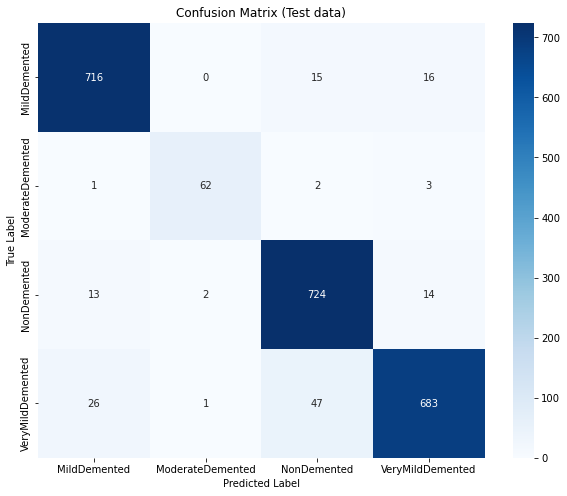

In [44]:
# Evaluate the model
true_labels, predictions = get_predictions(model2_generalization_test, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()